# Oefening deel 2: COP van een warmtepomp bepalen

> **Workshop Atic 4D**  
> **Lesgevers:** Lien De Backer & Jakob De Vreese

In deze oefening focussen we op de 4-pijps warmtepomp van ons gebouw. Hiervoor hebben we 4 datasets ter beschikking.

## Datasets

1) Elektrisch verbruik (2022 tot circa nu)
2) Warmte opwekking (2022 tot circa nu)
3) Warmte naar BEO-veld (2022 tot circa nu)
4) Warmte uit BEO-veld (2022 tot circa nu)

## Doel van de oefening

In dit deel van de oefening gaan we de COP van onze warmtepomp bepalen, het optimale rendement zoeken, en visualisaties maken.

### 🎯 Leerdoelen

Na deze oefening kun je:

- Meerdere energiestromen combineren en synchroniseren
- COP berekenen op verschillende tijdsschalen
- Data-kwaliteitsproblemen identificeren en aanpakken
- Energiebalansen opstellen en valideren
- Relaties met externe factoren (temperatuur) onderzoeken

### Structuur

- Packages importeren
- Data inladen en verkennen
- Data opschonen en voorbereiden
- Energiestromen combineren en valideren
- COP berekeningen per periode
- Visualisatie en analyse van COP-trends
- Relatie COP met externe factoren (proberen)
- Energiebalans BEO-veld
- Conclusies en aanbevelingen

## 📐 Theoretische achtergrond

### COP (Coefficient of Performance)

$$COP_{verwarming} = \frac{Q_{warmte,netto}}{W_{elektrisch}}$$

Waarbij:
- $Q_{warmte,netto}$ = warmte-output (kWh) - injectie gasketel
- $W_{elektrisch}$ = elektrisch verbruik (kWh)

Een typische warmtepomp heeft:
- **COP 3-5** bij gunstige condities (milde buitentemperatuur)
- **COP 2-3** bij koude condities
- **COP < 2** wijst op problemen

### Energiebalans BEO-veld

$$\Delta E_{BEO} = E_{onttrokken} - E_{geïnjecteerd}$$

Een gezond BEO-veld is in balans over het jaar (zomer: laden, winter: ontladen).

In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

## Stap 1: Data inladen

We laden volgende datasets in en _onderzoeken de data_:
- Elektrisch verbruik warmtepomp
- Warmte opwekking warmtepomp
- Koude opwekking warmtepomp
- Warmte naar BEO-veld
- Warmte uit BEO-veld

Hieronder krijg je een hulpfunctie om de data schoon in te laden van sommige datasets (wanneer aangegeven)

In [2]:
# Herbruikbare functie voor het inladen van GBS-export bestanden
def load_gbs_export(filepath, energy_cols_keywords, date_format='%m/%d/%y'):
    """
    Laad een tab-gescheiden GBS export bestand in.
    
    Parameters:
    -----------
    filepath : str
        Pad naar het bestand
    energy_cols_keywords : dict
        Dict met {nieuwe_naam: zoekterm} voor kolommen
    date_format : str
        Format van de datum in het bestand
        
    Returns:
    --------
    pd.DataFrame met DatetimeIndex en hernoemde kolommen
    """
    # Inladen
    df = pd.read_csv(filepath, sep='\t')
    
    # Verwijder Unnamed kolommen
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Zoek en hernoem energie kolommen
    rename_dict = {}
    for new_name, keyword in energy_cols_keywords.items():
        matching_cols = [c for c in df.columns if keyword.lower() in c.lower()]
        if matching_cols:
            rename_dict[matching_cols[0]] = new_name
    
    df = df.rename(columns=rename_dict)
    
    # Vind Time kolom
    time_col = 'Time' if 'Time' in df.columns else [c for c in df.columns if 'time' in c.lower()][0]
    
    # Parse datum (alleen deel voor komma)
    df['date'] = (
        df[time_col]
        .astype(str)
        .str.split(',', n=1)
        .str[0]
        .str.strip()
    )
    
    df['date'] = pd.to_datetime(df['date'], format=date_format, errors='coerce')
    df = df.dropna(subset=['date'])
    
    # Zet index en drop originele time kolom
    df = df.set_index('date').drop(columns=[time_col])
    
    # Selecteer alleen de hernoemde kolommen
    valid_cols = [col for col in energy_cols_keywords.keys() if col in df.columns]
    
    return df[valid_cols]

print("✓ Hulpfuncties gedefinieerd")

✓ Hulpfuncties gedefinieerd


### Elektrisch verbruik

Het elektrisch verbruik is handmatig uitgelezen en slechts ongeveer jaarlijks (onregelmatig) geregistreerd.

**Locatie**: `data/elek_WP_1102.csv`  
**Kolommen**: `datum`, `teller_30P1`  

In [3]:
# 2.1 Elektrisch verbruik warmtepomp (handmatig afgelezen)
elek = pd.read_csv('data/elek_WP_1102.csv', parse_dates=['datum'], index_col='datum')
elek.columns = elek.columns.str.replace('\ufeff', '', regex=False).str.strip()
elek = elek.sort_index()

print(f"📌 Elektrisch verbruik: {len(elek)} metingen van {elek.index.min():%Y-%m-%d} tot {elek.index.max():%Y-%m-%d}")
elek.head()

📌 Elektrisch verbruik: 9 metingen van 2020-02-26 tot 2025-09-15


,teller_30P1
datum,
2020-02-26,1259.3
2022-03-23,11454.0
2022-07-05,11488.0
2022-11-21,12191.0
2023-01-18,14303.0


<Axes: xlabel='datum'>

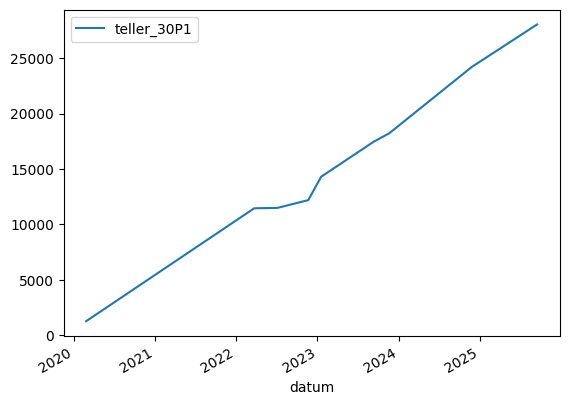

In [4]:
# Neem een snel kijkje!
elek.plot()

### Warmte- en koude-opwekking voorbereiden

Je werkt met een export uit het gebouwbeheersysteem (calorieteller van de warmtepomp aan de verbruikerszijde).  
**Bestand**: `data/calorieteller_wp.txt` (tab-gescheiden)  
**Kolommen**:
- Time: datum + tijd + tijdzone als tekst (bv. 5/29/20, 12:00:00 AM CEST)
- Twee zeer lange kolomnamen met cumulatieve energietellers (warm en koud) in kWh (let op: header bevat zowel MWh-tekst als kWh-eenheid).
- Eventueel een lege/Unnamed kolom.

> TIP! -> hier kunnen we de hulpfunctie gebruiken!

In [5]:
# 2.2 Warmte/koude opwekking warmtepomp
calorieteller_wp = load_gbs_export(
    'data/calorieteller_wp.txt',
    energy_cols_keywords={
        'opwekking_warm': 'energieverbruik warm',
        'opwekking_koud': 'energieverbruik koud'
    }
)

print(f"📌 Calorieteller WP: {len(calorieteller_wp)} dagen")
calorieteller_wp.head()

📌 Calorieteller WP: 1899 dagen


,opwekking_warm,opwekking_koud
date,,
2020-05-29,3195.0,10680.0
2020-05-30,3222.0,10691.0
2020-05-31,3237.0,10715.0
2020-06-01,3262.0,10736.0
2020-06-02,3288.0,10757.0


Neem een snel kijkje!

<Axes: xlabel='date'>

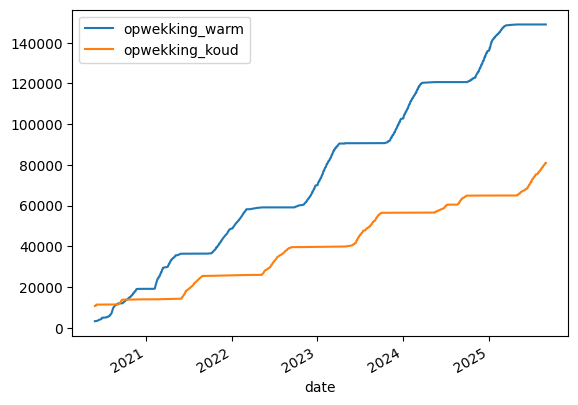

In [6]:
calorieteller_wp.plot()

#### Vragen voor reflectie

- Waarom is het nuttig de kolomnamen robuust te vinden i.p.v. hard te typen?
- Wat gebeurt er als je de tijdzone en tijd niet wegknipt?
- Wat is het verschil tussen cumulatieve meter en dagelijkse productie?

### Injectie gasketel dataset

Bekijk de kolomnamen in `data/calorieteller_injectie_LT.txt` en probeer de data in te laden met de hulpfunctie!

In [7]:
# 2.3 Injectie gasketel (backup warmte)
cal_injectie = load_gbs_export(
    'data/calorieteller_injectie_LT.txt',
    energy_cols_keywords={
        'injectie_warm': 'energieverbruik warm'
    }
)

print(f"📌 Injectie gasketel: {len(cal_injectie)} dagen")
cal_injectie.head()

📌 Injectie gasketel: 1899 dagen


,injectie_warm
date,
2020-05-29,3967.0
2020-05-30,3967.0
2020-05-31,3967.0
2020-06-01,3967.0
2020-06-02,3967.0


<Axes: xlabel='date'>

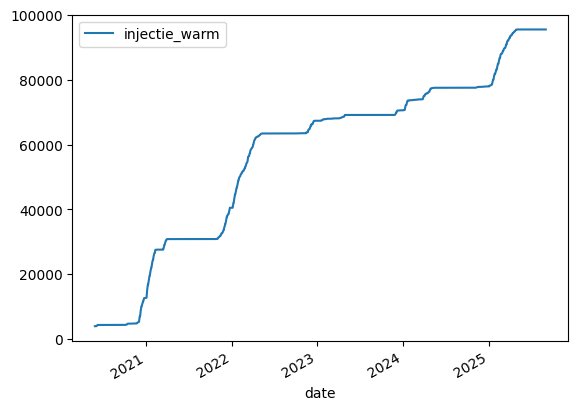

In [8]:
cal_injectie.plot()

### Calorieteller Beoveld inladen

Ga naar `data/calorieteller_beo.txt` en probeer de data correct in te laden!

In [9]:
# 2.4 BEO-veld (warmte in/uit bodem)
cal_beo = load_gbs_export(
    'data/calorieteller_beo.txt',
    energy_cols_keywords={
        'beo_warm': 'warm',  # Aanpassen naar exacte kolomnaam
        'beo_koud': 'koud'
    }
)

# Converteer van MWh naar kWh (indien nodig)
if cal_beo['beo_warm'].max() < 1000:  # Check of data in MWh staat
    cal_beo['beo_warm'] *= 1000
    cal_beo['beo_koud'] *= 1000

print(f"📌 BEO-veld: {len(cal_beo)} dagen")
cal_beo.head()

📌 BEO-veld: 1899 dagen


,beo_warm,beo_koud
date,,
2020-05-29,970.0000,320.0
2020-05-30,980.0000,350.0
2020-05-31,980.0000,420.0
2020-06-01,980.0000,440.0
2020-06-02,989.9999,460.0


<Axes: xlabel='date'>

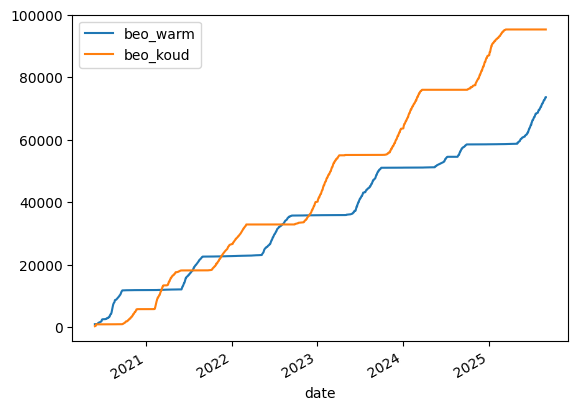

In [10]:
cal_beo.plot()

## 🔍 2. Data verkennen en visualiseren

Nu gaan we de data verkennen, naast elkaar plotten en reflecteren. 
We onderscheiden eenerzeids de cumulatieve meters, en anderzeids de dagelijkse verbruiken. 

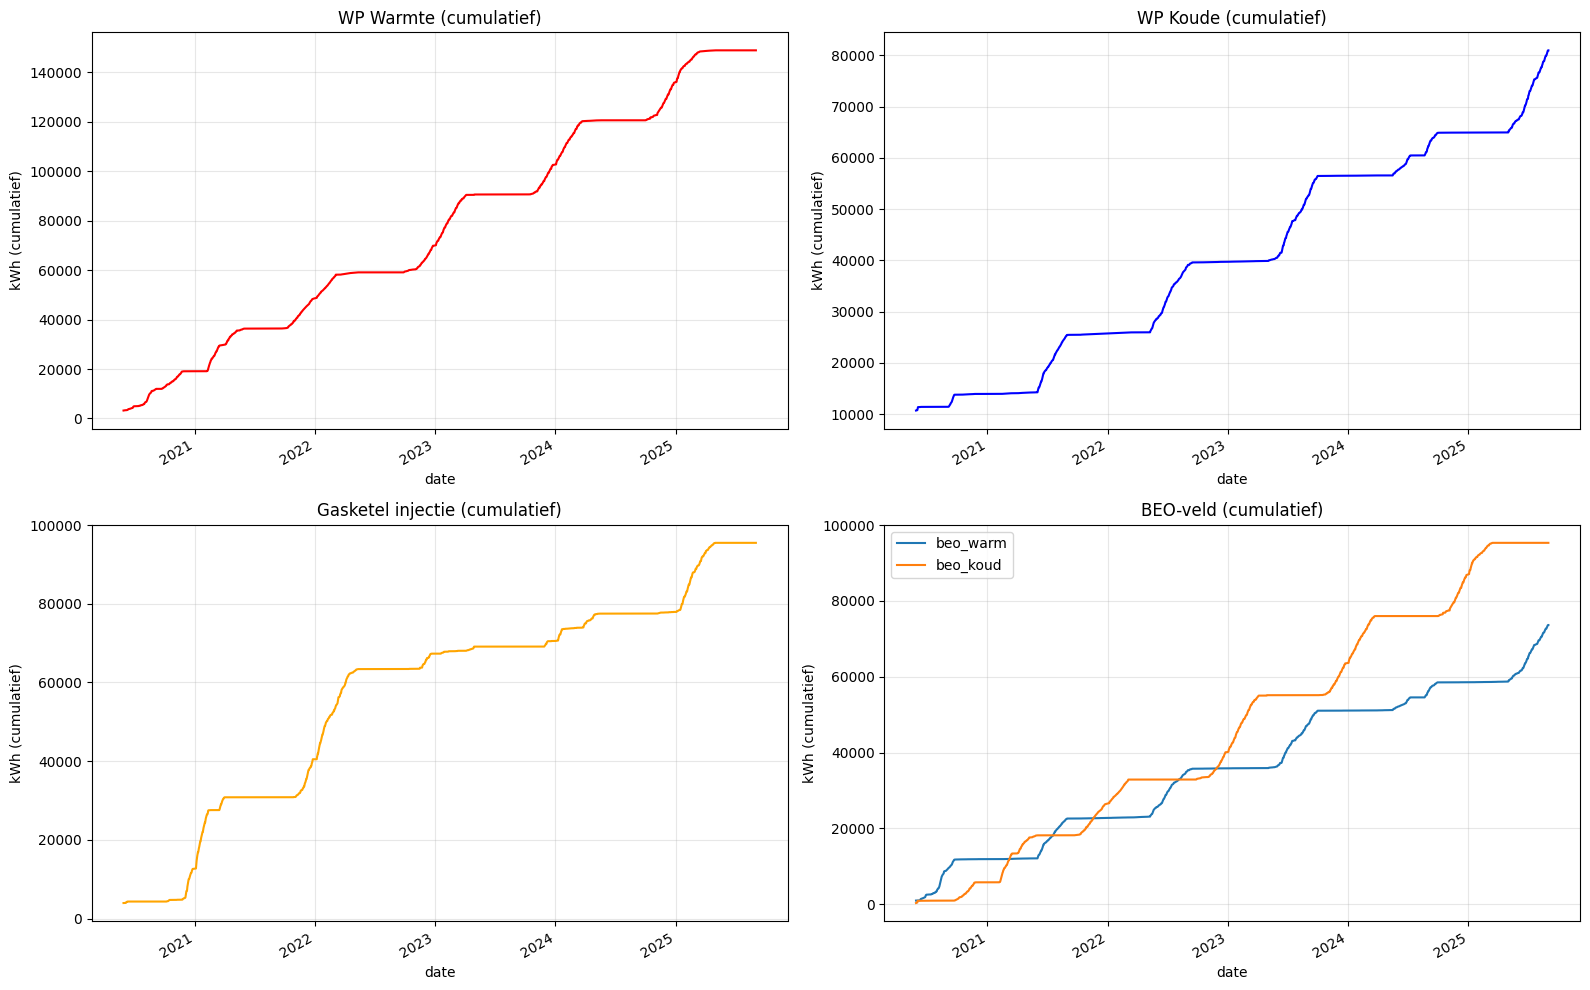

In [11]:
# 3.1 Overzicht cumulatieve meters
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

calorieteller_wp['opwekking_warm'].plot(ax=axes[0,0], title='WP Warmte (cumulatief)', color='red')
calorieteller_wp['opwekking_koud'].plot(ax=axes[0,1], title='WP Koude (cumulatief)', color='blue')
cal_injectie['injectie_warm'].plot(ax=axes[1,0], title='Gasketel injectie (cumulatief)', color='orange')
cal_beo.plot(ax=axes[1,1], title='BEO-veld (cumulatief)')

for ax in axes.flat:
    ax.set_ylabel('kWh (cumulatief)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

De **koude-opwekking** in ons systeem wordt _rechtstreeks_ verzorgd door het BEO-veld via een _platenwisselaar_. Hierbij komt geen warmtepomp kijken, wat betekent dat het _theoretische rendement_ gelijk zou moeten zijn aan ongeveer 1. 

Voor de **warmte-opwekking** is de situatie anders. Hier gebruiken we een warmtepomp, de output moet dus hoger zijn dan wat we uit het BEO-veld halen, en de factor is dan onze `COP`. Dit is een eerste manier hoe we de COP kunnen berekenen. 

Laten we eerst visualisaties maken om onze trend een eerste keer te analyseren, en patronen te proberen herkennen.

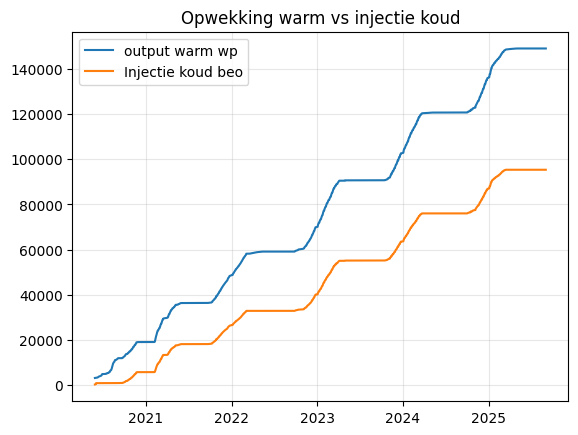

In [12]:
plt.Figure(figsize=(12,6))

plt.plot(calorieteller_wp.index, calorieteller_wp['opwekking_warm'], label='output warm wp')
plt.plot(cal_beo.index, cal_beo['beo_koud'], label='Injectie koud beo')

plt.title("Opwekking warm vs injectie koud")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

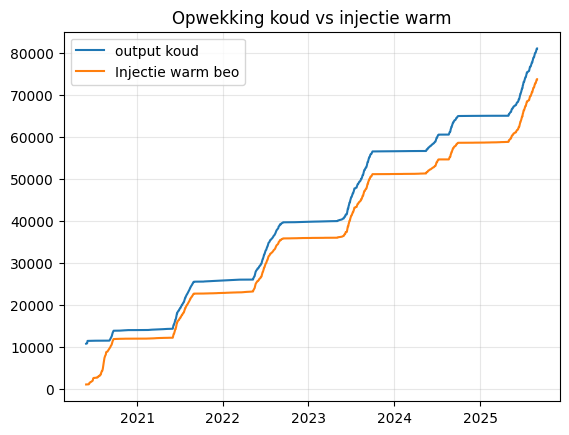

In [13]:
plt.Figure(figsize=(12,6))

plt.plot(calorieteller_wp.index, calorieteller_wp['opwekking_koud'], label='output koud')
plt.plot(cal_beo.index, cal_beo['beo_warm'], label='Injectie warm beo')

plt.title("Opwekking koud vs injectie warm")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## 3. 🧮 Berekening COP

De wet van behoud van energie stelt dat de energie die je uit het beo-veld haalt, plus de elektrische energie die je in de warmtepomp steekt gelijk moet zijn aan de warmte die je uit de warmtepomp haalt. Ofwel wiskundig:

$$
Q_{beo} + Q_{elek} = Q_{wp}
$$

$$
\frac{Q_{wp}}{Q_{elek}} = COP
$$

ofwel:

$$
\frac{Q_{beo} + Q_{elek}}{Q_{elek}} = COP
$$

Bovenstaande doen we, omdat er sterk vermoeden is dat de warmte die we uit de warmtepomp halen sterk bevuild is doordat de pomp draait, de warmtepomp uit, en de ketel warmte injecteert.

Dit houd wel geen rekening met elektrische verliezen van de warmtepomp. Maar laten we eens de COP zo berekenen.


In [14]:
totaal_elek = elek['teller_30P1'].max()
totaal_injectie_koud_beo = cal_beo['beo_koud'].max()

print(f'COP-berekening aan de hand elektrisch verbruik en beo injectie koud')
print()
print(f'Totaal elektrisch verbruik: {totaal_elek} kwh')
print(f'Totaal geinjecteerde koude beo: {totaal_injectie_koud_beo} kwh')
print()
print(f'COP: {(totaal_injectie_koud_beo + totaal_elek) / totaal_elek:.2f}')

COP-berekening aan de hand elektrisch verbruik en beo injectie koud

Totaal elektrisch verbruik: 28048.0 kwh
Totaal geinjecteerde koude beo: 95310.0 kwh

COP: 4.40


Volgens de technische fiche van de warmtepomp zouden we een SCOP van `4.4` moeten halen. Lukt dit?

### COP evolutie

Bekijk of er een evolutie in de COP zichtbaar is. Omdat we slechts weinig meetpunten voor elektrisch verbruik hebben, aggregeren we voor elk interval tussen twee elektriciteitsmeter‑aflezingen de dagelijkse BEO‑waarden: we sommeren de energie van het BEO‑veld binnen dat interval en koppelen die som aan de bijbehorende elektriciteitsmeting.

In [20]:
cop = elek.sort_index().copy()
cop['elektrisch_verbruik'] = cop['teller_30P1'].diff()
cop['beo_koud'] = np.nan

cal_beo['beo_koud_daily'] = cal_beo['beo_koud'].diff()

for i in range(1, len(cop)):
    d0 = cop.index[i-1]
    d1 = cop.index[i]
    mask = (cal_beo.index > d0) & (cal_beo.index <= d1)     # excl start, incl end
    cop.iloc[i, cop.columns.get_loc('beo_koud')] = cal_beo.loc[mask, 'beo_koud_daily'].sum()

cop['cop'] = (cop['beo_koud'] + cop['elektrisch_verbruik']) / cop['elektrisch_verbruik']

cop.head()

,teller_30P1,elektrisch_verbruik,beo_koud,cop
datum,,,,
2020-02-26,1259.3,NaN,NaN,NaN
2022-03-23,11454.0,10194.7,32560.0,4.193816
2022-07-05,11488.0,34.0,0.0,1.000000
2022-11-21,12191.0,703.0,2290.0,4.257468
2023-01-18,14303.0,2112.0,7800.0,4.693182


<Axes: xlabel='datum'>

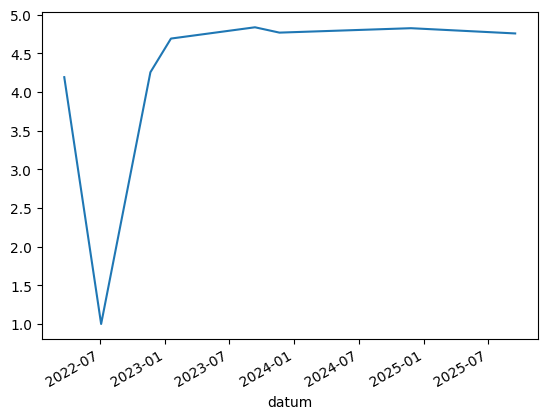

In [21]:
cop['cop'].plot()

## ⚖️ 4. Energiebalans BEO-veld

Een belangrijke factor bij BEO-velden om over langere tijd in de gaten te houden is of dit in balans blijft. Laten we dit eens voor onze installatie visualiseren, en een functie maken om het automatisch te berekenen bij andere installaties!

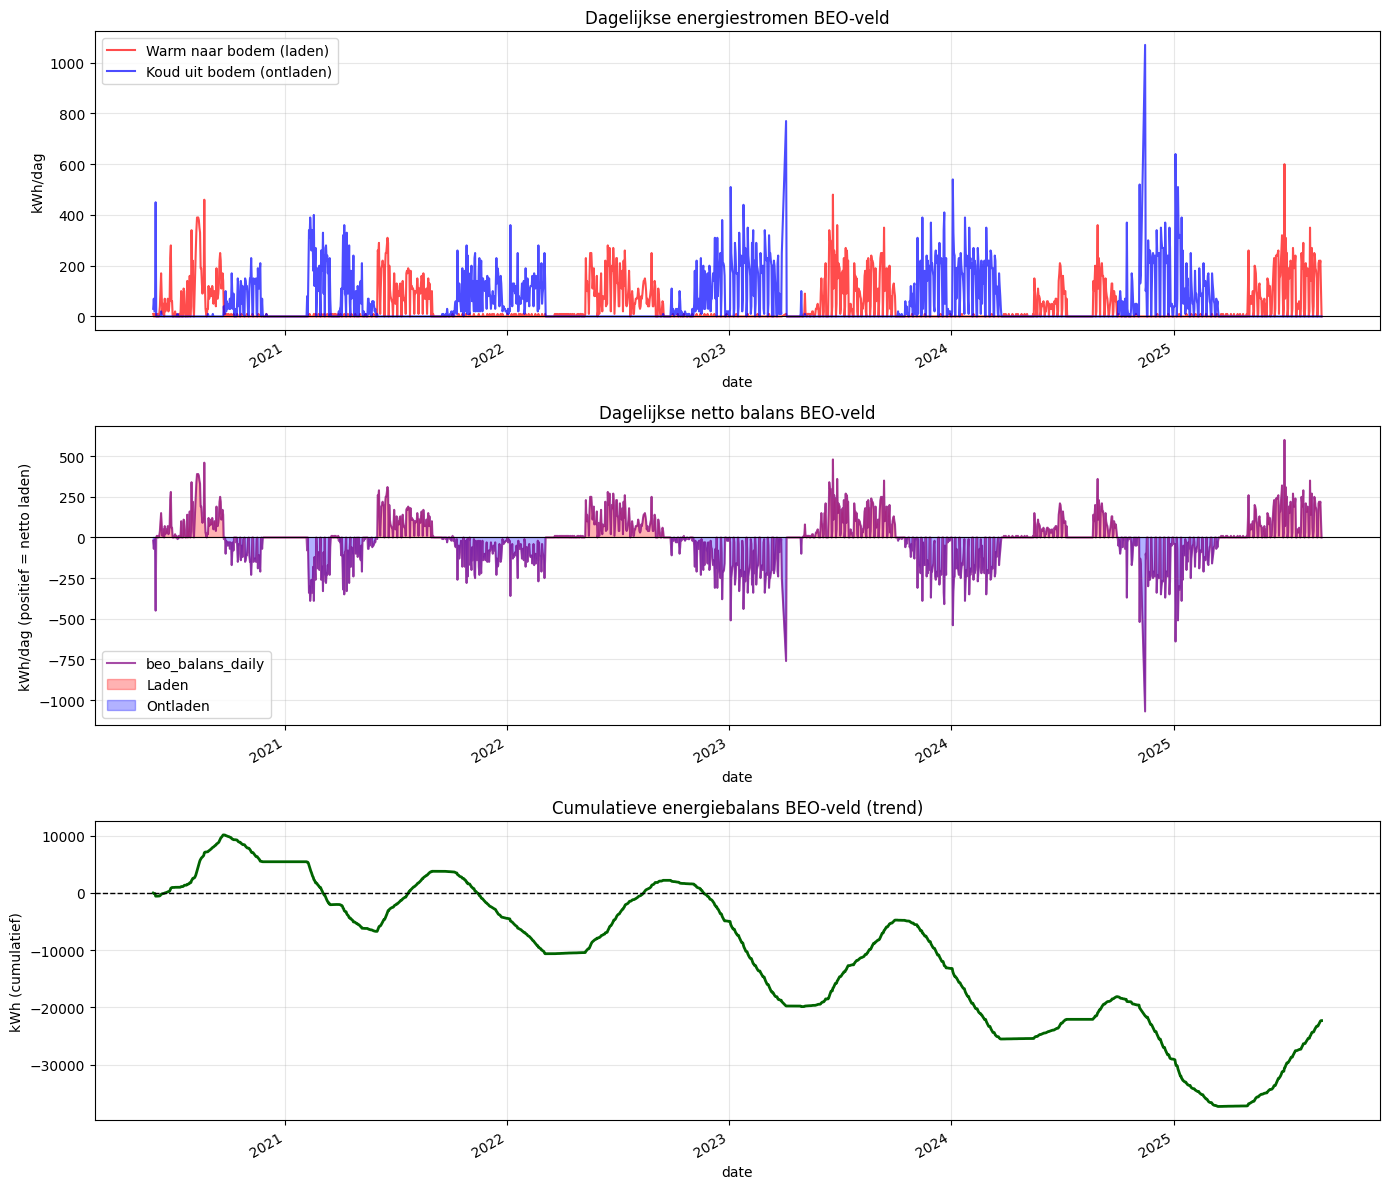

               BEO-VELD BALANS ANALYSE

📊 Totalen (volledige periode)
────────────────────────────────────────────────────────────
Totaal naar bodem (laden):           72,670 kWh
Totaal uit bodem (ontladen):         94,990 kWh
Netto balans:                       -22,320 kWh
Balans (%):                           -23.5 %

💡 Interpretatie
────────────────────────────────────────────────────────────
❌ Zorgelijk! Significante onevenwichtigheid (> 15%)
   → Bodem koelt af (meer ontladen dan laden)
   → Risico op verminderde verwarmingsprestaties in de winter




In [22]:
# 8.1 Bereken dagelijkse energiestromen BEO-veld
cal_beo['beo_warm_daily'] = cal_beo['beo_warm'].diff()
cal_beo['beo_koud_daily'] = cal_beo['beo_koud'].diff()
cal_beo['beo_balans_daily'] = cal_beo['beo_warm_daily'] - cal_beo['beo_koud_daily']

# Cumulatieve balans
cal_beo['beo_balans_cumul'] = cal_beo['beo_balans_daily'].cumsum()

# 8.2 Visualisatie energiebalans
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Grafiek 1: Dagelijkse in/uit stromen
cal_beo[['beo_warm_daily', 'beo_koud_daily']].plot(
    ax=axes[0],
    color=['red', 'blue'],
    alpha=0.7,
    title='Dagelijkse energiestromen BEO-veld'
)
axes[0].set_ylabel('kWh/dag')
axes[0].legend(['Warm naar bodem (laden)', 'Koud uit bodem (ontladen)'])
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Grafiek 2: Dagelijkse netto balans
cal_beo['beo_balans_daily'].plot(
    ax=axes[1],
    color='purple',
    alpha=0.7,
    title='Dagelijkse netto balans BEO-veld'
)
axes[1].set_ylabel('kWh/dag (positief = netto laden)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].fill_between(cal_beo.index, 0, cal_beo['beo_balans_daily'], 
                      where=cal_beo['beo_balans_daily']>=0, alpha=0.3, color='red', label='Laden')
axes[1].fill_between(cal_beo.index, 0, cal_beo['beo_balans_daily'], 
                      where=cal_beo['beo_balans_daily']<0, alpha=0.3, color='blue', label='Ontladen')
axes[1].legend()

# Grafiek 3: Cumulatieve balans (gezondheid bodem)
cal_beo['beo_balans_cumul'].plot(
    ax=axes[2],
    color='darkgreen',
    linewidth=2,
    title='Cumulatieve energiebalans BEO-veld (trend)'
)
axes[2].set_ylabel('kWh (cumulatief)')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# 8.3 Statistieken
print("="*60)
print(" "*15 + "BEO-VELD BALANS ANALYSE")
print("="*60)
print(f"\n📊 Totalen (volledige periode)")
print(f"{'─'*60}")
print(f"Totaal naar bodem (laden):     {cal_beo['beo_warm_daily'].sum():>12,.0f} kWh")
print(f"Totaal uit bodem (ontladen):   {cal_beo['beo_koud_daily'].sum():>12,.0f} kWh")
print(f"Netto balans:                  {cal_beo['beo_balans_daily'].sum():>12,.0f} kWh")

balans_pct = (cal_beo['beo_balans_daily'].sum() / cal_beo['beo_koud_daily'].sum() * 100)
print(f"Balans (%):                    {balans_pct:>12.1f} %")

print(f"\n💡 Interpretatie")
print(f"{'─'*60}")
if abs(balans_pct) < 5:
    print("✅ Uitstekend! BEO-veld is goed in balans (< 5%)")
elif abs(balans_pct) < 15:
    print("⚠️  Redelijk. Lichte onevenwichtigheid (5-15%)")
else:
    print("❌ Zorgelijk! Significante onevenwichtigheid (> 15%)")
    
if balans_pct > 0:
    print("   → Bodem warmt op (meer laden dan ontladen)")
    print("   → Risico op verminderde koelprestaties in de zomer")
else:
    print("   → Bodem koelt af (meer ontladen dan laden)")
    print("   → Risico op verminderde verwarmingsprestaties in de winter")

print(f"\n{'='*60}\n")

## 📝 9. Conclusies en aanbevelingen

Een belangrijke tool voor data analysten zijn eigen scriptjes die snel inzichten kunnen geven in specifieke datasets, met herbruikbare code. Dit is afhankelijk van het veld waarin je werkt, of van eigen accenten. Hieronder kan je een voorbeeld vinden van zo herbruikbare scripten!

In [25]:
cop.head()

,teller_30P1,elektrisch_verbruik,beo_koud,cop
datum,,,,
2020-02-26,1259.3,NaN,NaN,NaN
2022-03-23,11454.0,10194.7,32560.0,4.193816
2022-07-05,11488.0,34.0,0.0,1.000000
2022-11-21,12191.0,703.0,2290.0,4.257468
2023-01-18,14303.0,2112.0,7800.0,4.693182


In [39]:
# 9.1 Samenvatting
print("="*80)
print(" "*25 + "SAMENVATTING COP ANALYSE")
print("="*80)

print(f"\n📊 PRESTATIE-INDICATOREN")
print(f"{'─'*80}")
print(f"Gemiddelde COP (alle metingen):           {cop['cop'].mean():.2f}")
print(f"Mediaan COP:                              {cop['cop'].median():.2f}")
print(f"Beste COP gemeten:                        {cop['cop'].max():.2f}")
print(f"Slechtste COP gemeten:                    {cop['cop'].min():.2f}")

# Aanbevelingen op basis van COP
gemiddelde_cop = cop['cop'].mean()
if gemiddelde_cop >= 4.0:
    print("✅ COP is uitstekend (≥4.0). Systeem werkt optimaal.")
elif gemiddelde_cop >= 2.5:
    print("⚠️  COP is redelijk (2.5-4.0). Er is ruimte voor verbetering:")
    print("   • Check regelinstellingen warmtepomp")
    print("   • Onderzoek of aanvoertemperaturen verlaagd kunnen worden")
else:
    print("❌ COP is onder verwachting (<2.5). Actie vereist:")
    print("   • Technische inspectie warmtepomp noodzakelijk")
    print("   • Check koudemiddel niveau en drukken")
    print("   • Verificeer compressor werking")

print(f"\n📊 BEO-VELD BALANS")
print(f"{'─'*80}")
print(f"Totaal naar bodem (laden):                {cal_beo['beo_warm'].max():.2f} kWh")
print(f"Totaal uit bodem (ontladen):              {cal_beo['beo_koud'].max():.2f} kWh")
print(f"Netto balans:                             {cal_beo['beo_warm'].max() - cal_beo['beo_koud'].max():.2f} kWh")

# Aanbevelingen BEO
beo_balans_totaal = cal_beo['beo_warm'].max() - cal_beo['beo_koud'].max()
if abs(beo_balans_totaal) > 5000:
    print(f"\n⚠️  BEO-veld onevenwichtig ({beo_balans_totaal/1000:.1f} MWh):")
    if beo_balans_totaal > 0:
        print("   • Bodem warmt op → verhoogt risico op prestatievermindering")
        print("   • Evalueer of regeneratie van bodemveld nodig is")
    else:
        print("   • Bodem koelt af → verhoogt energieverbruik")
        print("   • Overweeg actieve kloeling in de zomer om te balanceren")

print(f"\n📊 ENERGIE-OVERZICHT (totaal)")
print(f"{'─'*80}")
print(f"Elektrisch verbruik WP:                      {elek['teller_30P1'].max()} kWh")
print(f"Geproduceerde warmte WP:                     {calorieteller_wp['opwekking_warm'].max()} kWh")
print(f'Warmteproductie BEO-veld:                    {cal_beo['beo_koud'].max()} kWh')
print(f"Koudeproductie Beo-veld:                     {cal_beo['beo_warm'].max()} kWh")

                         SAMENVATTING COP ANALYSE

📊 PRESTATIE-INDICATOREN
────────────────────────────────────────────────────────────────────────────────
Gemiddelde COP (alle metingen):           4.17
Mediaan COP:                              4.73
Beste COP gemeten:                        4.84
Slechtste COP gemeten:                    1.00
✅ COP is uitstekend (≥4.0). Systeem werkt optimaal.

📊 BEO-VELD BALANS
────────────────────────────────────────────────────────────────────────────────
Totaal naar bodem (laden):                73640.00 kWh
Totaal uit bodem (ontladen):              95310.00 kWh
Netto balans:                             -21670.00 kWh

⚠️  BEO-veld onevenwichtig (-21.7 MWh):
   • Bodem koelt af → verhoogt energieverbruik
   • Overweeg actieve kloeling in de zomer om te balanceren

📊 ENERGIE-OVERZICHT (totaal)
────────────────────────────────────────────────────────────────────────────────
Elektrisch verbruik WP:                      28048.0 kWh
Geproduceerde warmte W

-----
EINDE

------